In [78]:
import warnings
warnings.filterwarnings("ignore")

# ================================
# Core Libraries
# ================================
import os
import gc
import time
import copy
import random
from copy import deepcopy
from datetime import timedelta

# ================================
# Data Handling & Analysis
# ================================
import pandas as pd
import numpy as np

# ================================
# Spatial interpolation
# ================================
from pykrige.ok import OrdinaryKriging

pd.set_option('display.precision', 2)
# pd.options.mode.chained_assignment = None

# ================================
# Visualization
# ================================
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# Progress Bar
# ================================
from tqdm import tqdm

# ================================
# Scikit-Learn
# ================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.random import sample_without_replacement
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)
from scipy.stats import spearmanr, pearsonr, kurtosis, skew

# ================================
# PyTorch & PyTorch Geometric
# ================================
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, GRU

from torch_geometric.data import Data
from torch_geometric.data.data import DataEdgeAttr
from torch_geometric.nn import (
    GCNConv, GraphConv, ChebConv, NNConv, PNAConv, PDNConv,
    TransformerConv, GATv2Conv, TAGConv, CGConv, GENConv,
    GINEConv, LEConv
)
from torch_geometric.nn.norm import BatchNorm

torch.serialization.add_safe_globals([DataEdgeAttr])

# ================================
# Utility Functions
# ================================
def load(path):
    d = pd.read_csv(path, index_col=0)
    d.index = pd.to_datetime(d.index)
    d.index.name = ''
    return d

def scale_array(arr, method="standard"):
    """
    Scales a 2D NumPy array using Min-Max scaling or Standardization (Z-score normalization).
    
    Parameters:
        arr (np.ndarray): Input 2D NumPy array.
        method (str): Scaling method. Either 'minmax' (default) or 'standard'.
    
    Returns:
        np.ndarray: Scaled 2D array.
    """
    
    if method == "minmax":
        min_val = np.min(arr)
        max_val = np.max(arr)
        if max_val == min_val:
            return np.zeros_like(arr)  # Avoid division by zero
        return (arr - min_val) / (max_val - min_val)
    
    elif method == "standard":
        mean = np.mean(arr)
        std = np.std(arr)
        if std == 0:
            return np.zeros_like(arr)  # Avoid division by zero
        return (arr - mean) / std

def synchronize_many_dfs(dfs):
	# dfs should be a dictionary {"name": df, ...}
	min_max_values = []
	for name, df in dfs.items():
		min_max_values.append(df.index[0])
		min_max_values.append(df.index[-1])
	start = min(min_max_values)
	stop = max(min_max_values)
	#print(start, stop)
	idx = pd.date_range(start, stop, freq='h')
	new_dfs = []
	for name, df in dfs.items():
		dff = df
		dff = dff[~dff.index.duplicated(keep='first')]
		dff = dff.reindex(idx, fill_value=np.nan)
		dff.columns = dff.columns + "_" + name
		new_dfs.append(dff)
	return pd.concat(new_dfs, axis=1)


def calculate_typical_profiles(df):
    return df.groupby(df.index.hour).median()

# -----------------------------
def create_real_typical_dataset(subset_df, typical_profiles):
    df = subset_df.copy()
    for col in df.columns:
        if df[col].isna().all():
            df[col] = df.index.hour.map(typical_profiles[col])
    return df

# ================================
# Reproducibility
# ================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


ref_names = {'GR0018A':'Agia Sofia', 
             'GR0019A':'Kalamaria',
             'GR0020A':'Kordelio',
             'GR0044A':'Penepistimio',
             'GR0045A':'Neochorouda',
             'GR0046A':'Sindos',
             'GR0047A':'Agia Sofia',
             'GR0461A':'AUTH',
             'GR0462A':'PKM',
             'GR0463A':'Stavroupoli'
            }

# load KASTOM data for all nodes
paths = ['humidity.csv','pressure.csv','temperature.csv','pm_2_5.csv','pm_10.csv', 'pm_1_0.csv']
save_path = "/home/envitwin/Desktop/venvs/databases/data/kastom_data/hour/aggregates/"
to_keep = ['time', 'temperature', 'humidity', 'pressure', 'pm_10', 'pm_2_5', 'pm_1_0']
variables = ['pm_10', 'pm_1_0', 'pm_2_5', 'humidity', 'pressure', 'temperature']

kastom_nodes = sorted(os.listdir(save_path))
kastom_nodes = [x for x in kastom_nodes if 'kastom' in x]
kastom_dfs = {path[:-4]:load(save_path + path) for path in paths}
stations = kastom_dfs['pm_10'].columns # any variable will do
#cleaned_df = normalize_and_clean(kastom_dfs['humidity'], low=3.0, up=3.0, min_count=50)

exclude = ['nkastom08', 'nkastom19', 'nkastom23', 'nkastom25', 'nkastom28', 'nkastom29']#, 'nkastom23.csv'
stations = [f for f in stations if f not in exclude]

historical_df = kastom_dfs['pm_10']
historical_df = historical_df.loc[:,stations]

# Slice the first month
month_data = historical_df.loc['2020-01-01':'2020-01-31'].copy()

# Step 1: Normalize each sensor using min-max scaling
def min_max_normalize(series):
    if series.min() == series.max():  # avoid divide by zero
        return series - series  # all zeros
    return (series - series.min()) / (series.max() - series.min())

normalized = month_data#.apply(min_max_normalize, axis=0)

# Step 2: Extract hour of day for grouping
normalized['hour'] = normalized.index.hour

# Step 3: Compute diurnal profile per sensor (mean per hour)
diurnals = normalized.groupby('hour').mean().drop(columns='hour', errors='ignore')
normalized = normalized.drop(columns='hour', errors='ignore')

# Result: DataFrame of shape (24, n_sensors)
avg_diurnal = diurnals.mean(axis=1)
#diurnals.mean(axis=1).plot()
#plt.show()
#diurnals.plot()
#plt.show()


coordinates = {
        'nkastom04': {'lat': 40.631897, 'lon': 22.9406710000001},
        'nkastom07': {'lat': 40.645599, 'lon': 22.858091},
        #'nkastom08': {'lat': 40.57679000000005, 'lon': 22.970080000000053}, EXCLUDE BECAUSE THE DATA ARE SHIT
        'nkastom09': {'lat': 40.6339266, 'lon': 22.9729144},
        'nkastom10': {'lat': 40.686661, 'lon': 22.952488},
        'nkastom11': {'lat': 40.58216, 'lon': 22.95007},
        'nkastom12': {'lat': 40.641326, 'lon': 22.913513},
        'nkastom13': {'lat': 40.641326, 'lon': 22.95575},
        'nkastom14': {'lat': 40.673396000000004, 'lon': 22.928832000000057},
        'nkastom15': {'lat': 40.6375520955108, 'lon': 22.9410431299578},
        'nkastom16': {'lat': 40.63373, 'lon': 22.945150000000012},
        'nkastom17': {'lat': 40.644282, 'lon': 22.958302},
        'nkastom18': {'lat': 40.62678, 'lon': 22.9612500000001},
        'nkastom20': {'lat': 40.67351800000001, 'lon': 22.89320299999997},
        'nkastom22': {'lat': 40.65809499999999, 'lon': 22.80154600000003},
        #'nkastom23': {'lat': 40.60114, 'lon': 22.960505}, ALSO 19, 28 AND 29 ARE EXCLUDED BUT ARE NOT ON THIS LIST ANYWAY
        'nkastom24': {'lat': 40.6009789520081, 'lon': 22.9605397132275},
        'nkastom32': {'lat': 40.652402, 'lon': 22.9415289999999},
        'nkastom34': {'lat': 40.65349, 'lon': 22.922811},
        'nkastom35': {'lat': 40.63547, 'lon': 22.94154},
        'nkastom36': {'lat': 40.631992, 'lon': 22.944305},
        'nkastom37': {'lat': 40.60698, 'lon': 22.9552200000001},
        'nkastom38': {'lat': 40.6305, 'lon': 22.94868},
        'nkastom39': {'lat': 40.68281189704966, 'lon': 22.812980513855564},
        'nkastom40': {'lat': 40.667861, 'lon': 22.910971},
        'nkastom41': {'lat': 40.640383, 'lon': 22.935223},
        'nkastom42': {'lat': 40.6132239, 'lon': 22.9608034},
        'nkastom43': {'lat': 40.658643, 'lon': 22.942914},
        'nkastom44': {'lat': 40.59957, 'lon': 22.9880499999999},
        'nkastom45': {'lat': 40.63759, 'lon': 22.94902}
    }

def kriging_hourly_imputation(timestamp, df, coordinates, variogram_model='linear'):
    """
    Imputes missing values at a specific timestamp using Ordinary Kriging.
    Returns a Series with all columns preserved.
    """
    # Get full row for the timestamp
    full_row = df.loc[timestamp].copy()
    all_sensors = full_row.index.tolist()

    # Extract observed sensors with values and valid coordinates
    observed = full_row[full_row.notna()]
    observed = observed[observed.index.isin(coordinates.keys())]

    if len(observed) < 3:
        return full_row  # Not enough data to apply kriging

    # Build input data for kriging
    lats = [coordinates[s]['lat'] for s in observed.index]
    lons = [coordinates[s]['lon'] for s in observed.index]
    values = observed.values

    # Fit kriging model
    OK = OrdinaryKriging(
        lons, lats, values,
        variogram_model=variogram_model,
        verbose=False,
        enable_plotting=False
    )

    # Impute each missing sensor if coordinates are known
    for sensor in full_row[full_row.isna()].index:
        if sensor not in coordinates:
            continue  # skip if we can't locate the sensor

        try:
            lon, lat = coordinates[sensor]['lon'], coordinates[sensor]['lat']
            z, _ = OK.execute('points', [lon], [lat])
            full_row[sensor] = z[0]
        except Exception:
            pass  # fail-safe: skip this sensor if kriging errors

    # Ensure full_row has all original columns in the same order
    return full_row.reindex(all_sensors)

kriged_df = normalized.copy()

for t in normalized.index:  # or all timestamps
    kriged_df.loc[t] = kriging_hourly_imputation(t, kriged_df, coordinates)

kriged_df


,nkastom07,nkastom09,nkastom10,nkastom11,nkastom12,nkastom13,nkastom14,nkastom15,nkastom16,nkastom17,...,nkastom36,nkastom37,nkastom38,nkastom39,nkastom40,nkastom41,nkastom42,nkastom43,nkastom44,nkastom45
,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,48.0,42.0,40.0,43.64,43.40,42.0,41.05,43.75,46.0,42.02,...,44.01,42.91,43.46,44.93,41.24,43.51,42.39,41.91,42.11,43.24
2020-01-01 01:00:00+00:00,44.0,41.0,39.0,42.86,42.86,46.0,42.86,42.86,46.0,42.86,...,42.86,42.86,42.86,42.86,42.86,42.86,42.86,42.86,42.86,42.86
2020-01-01 02:00:00+00:00,65.5,61.0,56.0,61.82,61.41,60.0,59.08,61.54,65.0,60.17,...,61.82,61.27,61.46,62.34,59.75,61.35,60.88,59.77,60.59,61.19
2020-01-01 03:00:00+00:00,70.0,59.0,57.0,61.92,62.04,58.0,60.65,61.53,67.0,60.54,...,61.64,61.49,61.45,63.55,61.27,61.55,61.22,60.68,60.87,61.21
2020-01-01 04:00:00+00:00,78.0,65.0,61.0,65.86,65.86,63.0,65.86,65.86,73.0,65.86,...,65.86,65.86,65.86,65.86,65.86,65.86,65.86,65.86,65.86,65.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 19:00:00+00:00,182.0,356.5,345.0,272.28,272.28,252.0,160.00,272.28,378.0,272.28,...,368.00,244.00,272.28,272.28,272.28,272.28,233.00,247.00,272.28,272.28
2020-01-31 20:00:00+00:00,141.0,245.0,235.0,248.09,248.09,271.0,152.00,248.09,267.0,248.09,...,254.00,263.00,248.09,248.09,248.09,248.09,356.00,250.00,248.09,248.09
2020-01-31 21:00:00+00:00,145.0,233.0,223.0,230.06,230.06,246.5,145.00,230.06,253.0,230.06,...,244.00,250.00,230.06,230.06,230.06,230.06,240.00,240.50,230.06,230.06


In [79]:
alpha = 2

# 1. Get last day
last_day = kriged_df.loc['2020-01-31'].copy()
original_day = historical_df.loc['2020-01-31']

# 2. Prepare output
blended_day = last_day.copy()

# 3. Loop over each hour
for t in last_day.index:
    hour = t.hour
    diurnal_value = avg_diurnal[hour]

    # Get sensors that were missing in original data
    missing_cols = original_day.loc[t][original_day.loc[t].isna()].index

    for sensor in missing_cols:
        kriged_val = last_day.loc[t, sensor]
        if pd.notna(kriged_val):
            blended_val = alpha * kriged_val + (1 - alpha) * diurnal_value
            blended_day.loc[t, sensor] = blended_val

blended_day

,nkastom07,nkastom09,nkastom10,nkastom11,nkastom12,nkastom13,nkastom14,nkastom15,nkastom16,nkastom17,...,nkastom36,nkastom37,nkastom38,nkastom39,nkastom40,nkastom41,nkastom42,nkastom43,nkastom44,nkastom45
,,,,,,,,,,,,,,,,,,,,,
2020-01-31 00:00:00+00:00,59.0,66.0,62.0,-44.08,-44.08,68.5,-44.08,-44.08,73.0,-44.08,...,69.0,62.0,-44.08,-44.08,-44.08,-44.08,60.00,66.0,-44.08,-44.08
2020-01-31 01:00:00+00:00,81.0,56.0,53.0,-60.14,-60.14,38.0,-60.14,-60.14,59.0,-60.14,...,58.0,38.0,-60.14,-60.14,-60.14,-60.14,36.50,35.0,-60.14,-60.14
2020-01-31 02:00:00+00:00,71.0,59.0,57.0,-10.74,-10.74,116.0,-10.74,-10.74,63.0,-10.74,...,65.5,120.0,-10.74,-10.74,-10.74,-10.74,104.00,104.5,-10.74,-10.74
2020-01-31 03:00:00+00:00,103.0,100.0,95.0,53.18,53.18,180.0,53.18,53.18,109.0,53.18,...,109.5,167.0,53.18,53.18,53.18,53.18,183.00,161.0,53.18,53.18
2020-01-31 04:00:00+00:00,140.0,129.0,123.5,82.41,82.41,165.0,82.41,82.41,139.0,82.41,...,132.5,163.0,82.41,82.41,82.41,82.41,144.00,166.5,82.41,82.41
2020-01-31 05:00:00+00:00,298.0,138.0,126.5,91.40,91.40,146.0,129.00,91.40,143.5,91.40,...,143.5,146.0,91.40,91.40,91.40,91.40,141.00,133.0,91.40,91.40
2020-01-31 06:00:00+00:00,189.0,223.0,214.5,130.20,130.20,142.0,67.00,130.20,237.0,130.20,...,229.5,160.0,130.20,130.20,130.20,130.20,141.00,150.0,130.20,130.20
2020-01-31 07:00:00+00:00,69.0,228.0,214.0,73.17,73.17,65.0,78.00,73.17,244.0,73.17,...,235.0,66.0,73.17,73.17,73.17,73.17,55.00,59.0,73.17,73.17
2020-01-31 08:00:00+00:00,51.0,137.0,132.0,0.02,0.02,47.5,66.50,0.02,146.0,0.02,...,143.0,43.0,0.02,0.02,0.02,0.02,45.50,46.0,0.02,0.02


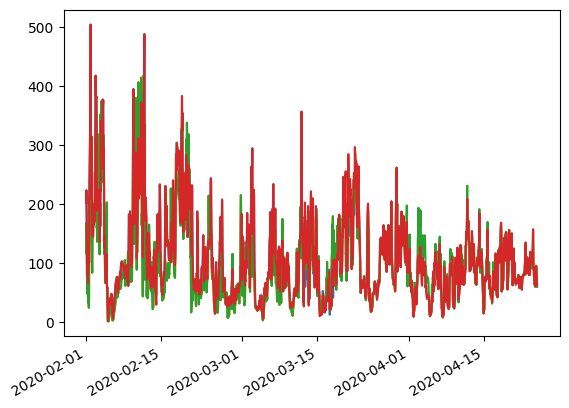

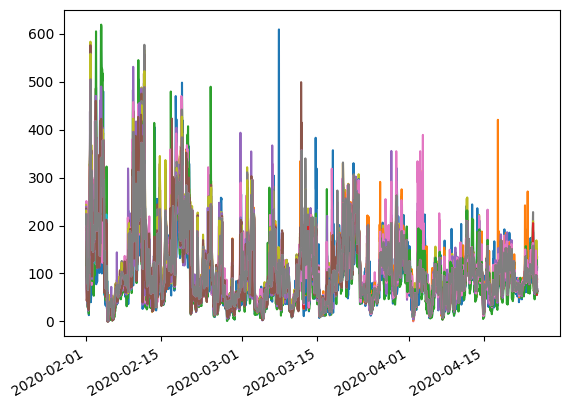

<Axes: >

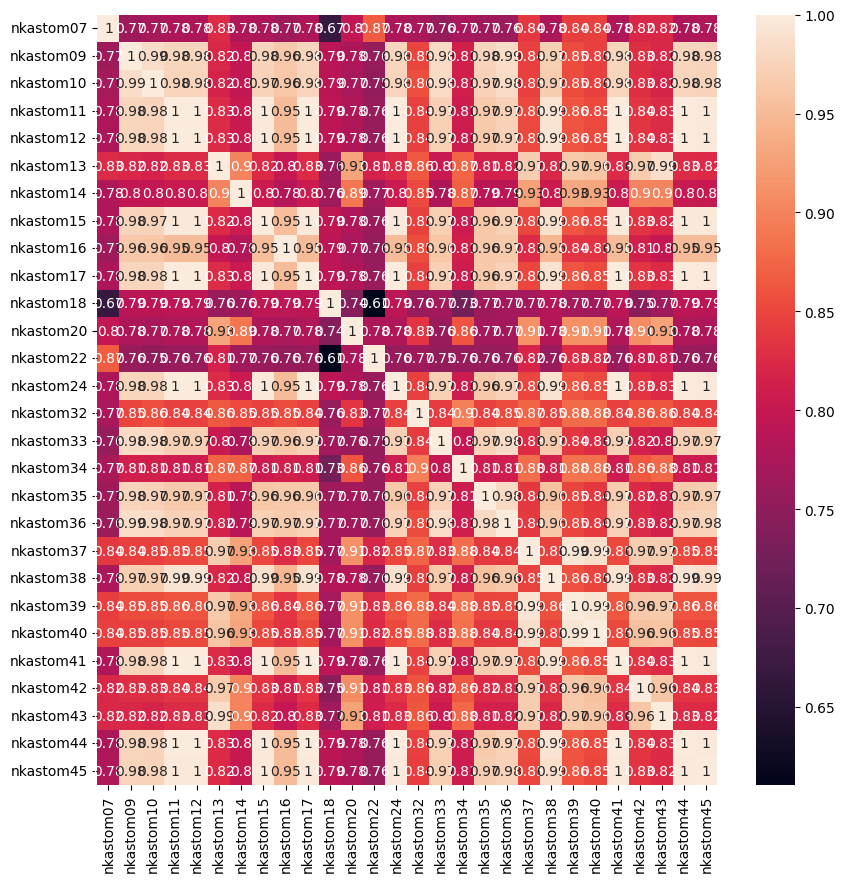

In [81]:
# Slice the first month
data = historical_df.loc['2020-02-01':].copy()
timesteps = data.index[:2000]
start = data.index[0]

data_n = data#.apply(min_max_normalize, axis=0)

window_size = 23
step_size = 1

# Rolling loop
imputed_rows = []
rng = np.random.default_rng(seed=int(pd.Timestamp(start).timestamp()) % 2**32)
for start in timesteps:
    imputer = KNNImputer(n_neighbors=2)
    subset_real = data_n.loc[start, :].copy()
    
    # masks for evaluation
    observed_mask = subset_real.notna()
    missing_mask = subset_real.isna()
    eval_fraction = 0.2
    #rng = np.random.default_rng(42)  # Or use np.random.seed(42) + np.random.choice
    observed_cols = observed_mask[observed_mask].index
    mask_size = max(1, int(len(observed_cols) * eval_fraction))
    
    artificial_nan_cols = rng.choice(observed_cols, size=mask_size, replace=False)
    artificial_nan_mask = pd.Series(False, index=subset_real.index)
    artificial_nan_mask.loc[artificial_nan_cols] = True
    #print("Observed columns:", observed_mask[observed_mask].index.tolist())
    #print("Missing columns:", missing_mask[missing_mask].index.tolist())
    #print("Artificial columns:", artificial_nan_mask[artificial_nan_mask].index.tolist())
    eval_row = subset_real.copy()
    eval_row[artificial_nan_mask] = np.nan

    eval_df = pd.concat([blended_day, pd.DataFrame([eval_row])]).iloc[1:]
    #print(eval_df.iloc[-1,:])
    imputed_df = pd.DataFrame(imputer.fit_transform(eval_df), columns=eval_df.columns, index=eval_df.index)
    # ADD HERE THE CALCULATION OF METRICS
    
    blended_day = pd.concat([blended_day, pd.DataFrame([subset_real])]).iloc[1:,:]
        
    blended_day = pd.DataFrame(imputer.fit_transform(blended_day.T).T, columns=blended_day.columns, index=blended_day.index)
    imputed_rows.append(imputed_df.iloc[-1,:])
pd.DataFrame(imputed_rows)[['nkastom38', 'nkastom39', 'nkastom40', 'nkastom41']].plot(legend=False); plt.show()
pd.DataFrame(imputed_rows).plot(legend=False); plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(pd.DataFrame(imputed_rows).corr(), annot=True)

In [7]:
67393/12

5616.083333333333

<Axes: >

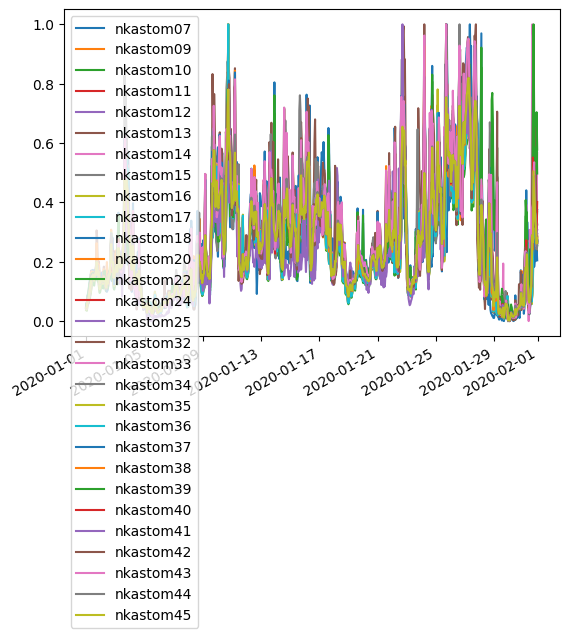

In [3]:
coordinates = {
        'nkastom04': {'lat': 40.631897, 'lon': 22.9406710000001},
        'nkastom07': {'lat': 40.645599, 'lon': 22.858091},
        #'nkastom08': {'lat': 40.57679000000005, 'lon': 22.970080000000053}, EXCLUDE BECAUSE THE DATA ARE SHIT
        'nkastom09': {'lat': 40.6339266, 'lon': 22.9729144},
        'nkastom10': {'lat': 40.686661, 'lon': 22.952488},
        'nkastom11': {'lat': 40.58216, 'lon': 22.95007},
        'nkastom12': {'lat': 40.641326, 'lon': 22.913513},
        'nkastom13': {'lat': 40.641326, 'lon': 22.95575},
        'nkastom14': {'lat': 40.673396000000004, 'lon': 22.928832000000057},
        'nkastom15': {'lat': 40.6375520955108, 'lon': 22.9410431299578},
        'nkastom16': {'lat': 40.63373, 'lon': 22.945150000000012},
        'nkastom17': {'lat': 40.644282, 'lon': 22.958302},
        'nkastom18': {'lat': 40.62678, 'lon': 22.9612500000001},
        'nkastom20': {'lat': 40.67351800000001, 'lon': 22.89320299999997},
        'nkastom22': {'lat': 40.65809499999999, 'lon': 22.80154600000003},
        #'nkastom23': {'lat': 40.60114, 'lon': 22.960505}, ALSO 19, 28 AND 29 ARE EXCLUDED BUT ARE NOT ON THIS LIST ANYWAY
        'nkastom24': {'lat': 40.6009789520081, 'lon': 22.9605397132275},
        'nkastom32': {'lat': 40.652402, 'lon': 22.9415289999999},
        'nkastom34': {'lat': 40.65349, 'lon': 22.922811},
        'nkastom35': {'lat': 40.63547, 'lon': 22.94154},
        'nkastom36': {'lat': 40.631992, 'lon': 22.944305},
        'nkastom37': {'lat': 40.60698, 'lon': 22.9552200000001},
        'nkastom38': {'lat': 40.6305, 'lon': 22.94868},
        'nkastom39': {'lat': 40.68281189704966, 'lon': 22.812980513855564},
        'nkastom40': {'lat': 40.667861, 'lon': 22.910971},
        'nkastom41': {'lat': 40.640383, 'lon': 22.935223},
        'nkastom42': {'lat': 40.6132239, 'lon': 22.9608034},
        'nkastom43': {'lat': 40.658643, 'lon': 22.942914},
        'nkastom44': {'lat': 40.59957, 'lon': 22.9880499999999},
        'nkastom45': {'lat': 40.63759, 'lon': 22.94902}
    }

def kriging_hourly_imputation(timestamp, df, coordinates, variogram_model='linear'):
    """
    Imputes missing values at a specific timestamp using Ordinary Kriging.
    Returns a Series with all columns preserved.
    """
    # Get full row for the timestamp
    full_row = df.loc[timestamp].copy()
    all_sensors = full_row.index.tolist()

    # Extract observed sensors with values and valid coordinates
    observed = full_row[full_row.notna()]
    observed = observed[observed.index.isin(coordinates.keys())]

    if len(observed) < 3:
        return full_row  # Not enough data to apply kriging

    # Build input data for kriging
    lats = [coordinates[s]['lat'] for s in observed.index]
    lons = [coordinates[s]['lon'] for s in observed.index]
    values = observed.values

    # Fit kriging model
    OK = OrdinaryKriging(
        lons, lats, values,
        variogram_model=variogram_model,
        verbose=False,
        enable_plotting=False
    )

    # Impute each missing sensor if coordinates are known
    for sensor in full_row[full_row.isna()].index:
        if sensor not in coordinates:
            continue  # skip if we can't locate the sensor

        try:
            lon, lat = coordinates[sensor]['lon'], coordinates[sensor]['lat']
            z, _ = OK.execute('points', [lon], [lat])
            full_row[sensor] = z[0]
        except Exception:
            pass  # fail-safe: skip this sensor if kriging errors

    # Ensure full_row has all original columns in the same order
    return full_row.reindex(all_sensors)

kriged_df = normalized.copy()

for t in normalized.index:  # or all timestamps
    kriged_df.loc[t] = kriging_hourly_imputation(t, kriged_df, coordinates)

kriged_df.plot()

In [ ]:
window_size = 23
step_size = 1

# Prepare initial subsets
initial_subset = historical_df.iloc[:24, :]
kickstart_df = create_real_typical_dataset(initial_subset, typical_profiles)
subset_real = historical_df.iloc[24:48, :].copy()
idx = pd.concat([kickstart_df, subset_real]).index
kickstart_df2 = pd.DataFrame(imputer.fit_transform(pd.concat([kickstart_df, subset_real])), columns=subset_real.columns, index=idx)
timesteps = historical_df.index[48:]

# Rolling loop
imputed_rows = []
rng = np.random.default_rng(seed=int(pd.Timestamp(start).timestamp()) % 2**32)
for start in timesteps:
    imputer = KNNImputer(n_neighbors=5)
    subset_real = historical_df.loc[start, :].copy()
    
    # masks for evaluation
    observed_mask = subset_real.notna()
    missing_mask = subset_real.isna()
    eval_fraction = 0.2
    #rng = np.random.default_rng(42)  # Or use np.random.seed(42) + np.random.choice
    observed_cols = observed_mask[observed_mask].index
    mask_size = max(1, int(len(observed_cols) * eval_fraction))
    
    artificial_nan_cols = rng.choice(observed_cols, size=mask_size, replace=False)
    artificial_nan_mask = pd.Series(False, index=subset_real.index)
    artificial_nan_mask.loc[artificial_nan_cols] = True
    #print("Observed columns:", observed_mask[observed_mask].index.tolist())
    #print("Missing columns:", missing_mask[missing_mask].index.tolist())
    print("Artificial columns:", artificial_nan_mask[artificial_nan_mask].index.tolist())
    eval_row = subset_real.copy()
    eval_row[artificial_nan_mask] = np.nan

    eval_df = pd.concat([kickstart_df2, pd.DataFrame([eval_row])]).iloc[1:]
    #print(eval_df.iloc[-1,:])
    imputed_df = pd.DataFrame(imputer.fit_transform(eval_df.T).T, columns=eval_df.columns, index=eval_df.index)
    # ADD HERE THE CALCULATION OF METRICS
    
    kickstart_df2 = pd.concat([kickstart_df2, pd.DataFrame([subset_real])]).iloc[1:]
    #print(kickstart_df2.iloc[-1,:])
    
        
    imputed_df = pd.DataFrame(imputer.fit_transform(kickstart_df2), columns=kickstart_df2.columns, index=kickstart_df2.index)
    imputed_rows.append(imputed_df.iloc[-1,:])
    print(pd.DataFrame(imputed_rows).iloc[:,:4])


# load EEA REFERENCE data for all stations
target = 'PM10'
ref_path = f"/home/envitwin/Desktop/venvs/databases/data/eea_data/data/{target}/thessaloniki/raw/"
ref_nodes = sorted(os.listdir(ref_path))

ref_stations = [x for x in ref_nodes if '.csv' in x]
ref_dfs = {path[:-4]:load(ref_path + path) for path in ref_stations}
ref_df = synchronize_many_dfs(ref_dfs)
ref_df = ref_df.loc['2020-01-01 00:00:00+00:00':]
print(ref_df)

#sns.heatmap(ref_df.isna())
#plt.savefig("missing_heatmap.png", dpi=200)

                           nkastom07  nkastom08  nkastom09  nkastom10  \
                                                                        
2020-01-01 00:00:00+00:00       48.0        NaN       42.0       40.0   
2020-01-01 01:00:00+00:00       44.0        NaN       41.0       39.0   
2020-01-01 02:00:00+00:00       65.5        NaN       61.0       56.0   
2020-01-01 03:00:00+00:00       70.0        NaN       59.0       57.0   
2020-01-01 04:00:00+00:00       78.0        NaN       65.0       61.0   
...                              ...        ...        ...        ...   
2025-07-10 04:00:00+00:00        0.0        NaN       37.5        NaN   
2025-07-10 05:00:00+00:00        0.0        NaN       54.0        NaN   
2025-07-10 06:00:00+00:00        NaN        NaN       54.0        NaN   
2025-07-11 08:00:00+00:00        NaN        NaN       37.5        NaN   
2025-07-11 09:00:00+00:00        1.0        NaN       34.0        NaN   

                           nkastom11  nkastom12  n

ValueError: Shape of passed values is (48, 16), indices imply (48, 31)

In [2]:
historical_df

,nkastom07,nkastom08,nkastom09,nkastom10,nkastom11,nkastom12,nkastom13,nkastom14,nkastom15,nkastom16,...,nkastom36,nkastom37,nkastom38,nkastom39,nkastom40,nkastom41,nkastom42,nkastom43,nkastom44,nkastom45
,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,48.0,NaN,42.0,40.0,NaN,NaN,42.0,NaN,NaN,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00+00:00,44.0,NaN,41.0,39.0,NaN,NaN,46.0,NaN,NaN,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00+00:00,65.5,NaN,61.0,56.0,NaN,NaN,60.0,NaN,NaN,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00+00:00,70.0,NaN,59.0,57.0,NaN,NaN,58.0,NaN,NaN,67.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00+00:00,78.0,NaN,65.0,61.0,NaN,NaN,63.0,NaN,NaN,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-10 04:00:00+00:00,0.0,NaN,37.5,NaN,NaN,189.0,NaN,7.0,NaN,NaN,...,115.0,NaN,15.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2025-07-10 05:00:00+00:00,0.0,NaN,54.0,NaN,NaN,186.0,NaN,7.0,NaN,NaN,...,NaN,NaN,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-10 06:00:00+00:00,NaN,NaN,54.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,...,NaN,NaN,10.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
